In [1]:
import os, sys
sys.path.insert(0, os.path.abspath(os.path.join("..", "..")))

# Chicago data

Now with no Gaussian decay

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sepp.sepp_grid
import sepp.sepp_grid_space
import open_cp.logger
open_cp.logger.log_to_true_stdout("sepp")

In [3]:
import open_cp.sources.chicago
import open_cp.geometry
import opencrimedata.chicago
import descartes
import pickle, lzma, datetime
import open_cp.predictors
import open_cp.kernels

In [4]:
datadir = os.path.join("..", "..", "..", "..", "..", "Data")
#datadir = os.path.join("/media", "disk", "Data")
open_cp.sources.chicago.set_data_directory(datadir)

with lzma.open(os.path.join(datadir, "chicago_redist_network_flow_to_buildings_network.csv.xz"), "rt") as file:
    all_points = opencrimedata.chicago.load_to_open_cp(file, "BURGLARY")

In [5]:
northside = open_cp.sources.chicago.get_side("North")
grid = open_cp.data.Grid(150, 150, 0, 0)
grid = open_cp.geometry.mask_grid_by_intersection(northside, grid)

In [6]:
mask = (all_points.timestamps >= np.datetime64("2016-01-01")) & (all_points.timestamps < np.datetime64("2017-01-01"))
points = all_points[mask]
points = open_cp.geometry.intersect_timed_points(points, northside)

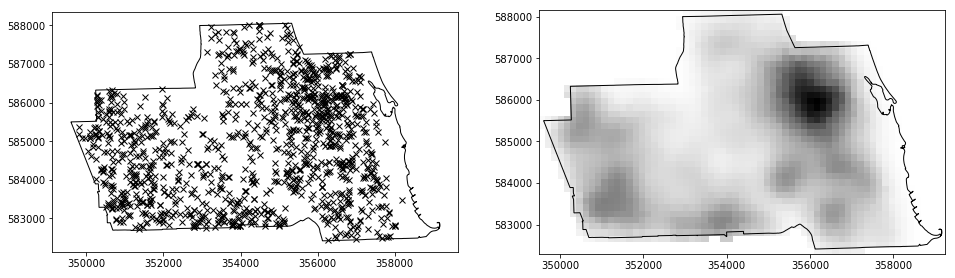

In [7]:
fig, axes = plt.subplots(ncols=2, figsize=(16,10))

ax = axes[0]
ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
ax.set_aspect(1)
ax.scatter(points.xcoords, points.ycoords, marker="x", color="black", linewidth=1)

kernel = open_cp.kernels.GaussianBase(points.coords)
kernel.bandwidth = 300
kernel.covariance_matrix = [[1,0], [0,1]]
_pred = open_cp.predictors.grid_prediction_from_kernel_and_masked_grid(kernel, grid, samples=5)
ax = axes[1]
ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
ax.set_aspect(1)
ax.pcolor(*_pred.mesh_data(), _pred.intensity_matrix, cmap="Greys", rasterized=True)
None

## Train

In [8]:
trainer = sepp.sepp_grid_space.Trainer2(grid, 20)
trainer.data = points
model = trainer.train(datetime.datetime(2017,1,1), iterations=50)
model

Model2(mu size=(39, 65), T=365.9583333333333, grid=RectangularRegion( (349500,582300) -> (359250,588150) ), theta=0.010190495562814688, omega=0.11730274607630123, r0=20

In [9]:
predictor = trainer.to_predictor(model)
predictor.data = trainer.data
pred1 = predictor.predict(datetime.datetime(2017,1,1))
pred2 = predictor.predict(datetime.datetime(2016,9,1))
pred3 = predictor.predict(datetime.datetime(2016,10,15))

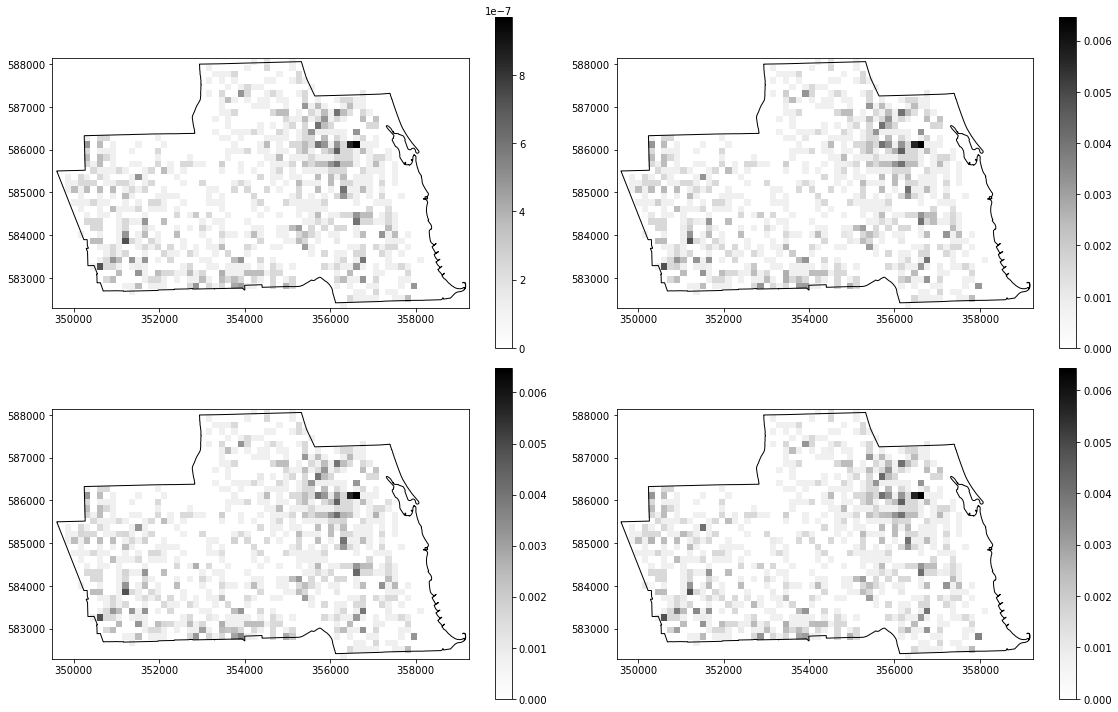

In [10]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(16,10))

for ax in axes.flat:
    ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
    ax.set_aspect(1)

bpred = open_cp.predictors.GridPredictionArray(grid.xsize, grid.ysize, model.mu, grid.xoffset, grid.yoffset)

for ax, pred in zip(axes.flat, [bpred, pred1, pred2, pred3]):
    m = ax.pcolor(*pred.mesh_data(), pred.intensity_matrix, cmap="Greys", rasterized=True)
    cb = fig.colorbar(m, ax=ax)
fig.tight_layout()

# How it changes with $r_0$

Can't start with $r_0$ being too small, or edge converges to "no triggering" which the base library raises as an exception (_maybe_ it shouldn't do this...  but it does, for now).

In [11]:
r0_range = np.exp(np.linspace(1, np.log(100), 100))
models = {}
for r0 in r0_range:
    trainer = sepp.sepp_grid_space.Trainer2(grid, r0)
    trainer.data = points
    models[r0] = trainer.train(datetime.datetime(2017,1,1), iterations=50)

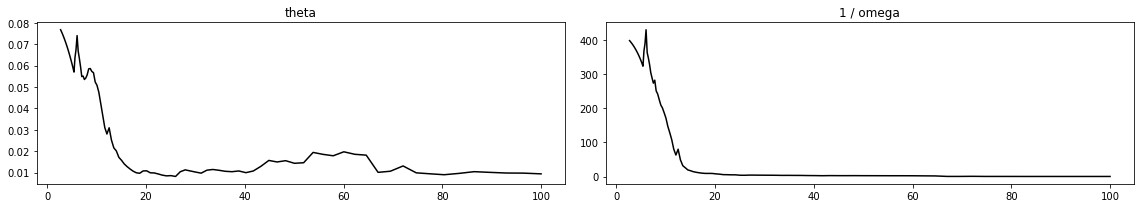

In [12]:
fig, axes = plt.subplots(ncols=2, figsize=(16,3))

axes[0].plot(r0_range, [models[r].theta for r in r0_range], color="black")
axes[0].set(title="theta")
axes[1].plot(r0_range, [1/models[r].omega for r in r0_range], color="black")
axes[1].set(title="1 / omega")

fig.tight_layout()
#fig.savefig("../varying_r0_no_g.pdf")